# Explaining Facial Expression Recognition
## Notebook 2:  XAI for Affective Computing (SoSe2022)

Description here

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the **README** beforing starting this notebook, to review the required Python packages. 

## Part 0: Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

##### Import necessary libraries

(see README for necessary package installations if you receive a `module not found` error.

In [2]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import tensorflow for model loading
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# required for ALIBI Contrastive Explanation Methods (CEM)
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

# import sklearn for processing data and results
from sklearn.preprocessing import LabelBinarizer

from skimage import io

# import model loading function
from model import cnn_model

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### Helper functions for plotting faces

In [3]:
# Helper Functions
def display_one_image(image, title, subplot, color='black', mask=None):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image, )
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, preds, start, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        idx = start+i
        display_one_image(images[idx], f'Actual={titles[idx]} \n Pred={preds[idx]} \n Index = {idx}', 331+i, color)
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

##### Some Global Variables

In [4]:
SEED = 12
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 80 # set to 80 to easily load all images using image generator in one call
NUM_CLASSES = 8
CLASS_LABELS = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

## Part 1: Model Setup

### CNN Model - Facial Expression Recognition from Images
This model is a pretrained Convolutional Neural Network for Facial Expression Recognition (FER) trained on raw images of people making facial expressions, from a subset of the [AffectNet dataset](http://mohammadmahoor.com/affectnet/). 

This is the same model as our previous notebook 

#### Load the pretrained model 


In [5]:
# make sure you've downloaded the models from LernraumPlus (see README instructions for Notebook I)
model_path = '../models/affectnet_model_e=60/affectnet_model'

# test loading weights
fer_cnn_model = cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
fer_cnn_model.load_weights(model_path)

2022-06-04 22:51:41.323813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-04 22:51:41.966038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
2022-06-04 22:51:41.998303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


#### Load the images to be explained
`ImageDataGenerator` is a [Keras utility class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to easily load images for processing with a Keras model.

The numpy array `X_img` contains 80 images that we will use for explanations.  And `Y_img_true` stores the ground truth labels, encoded as [one hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), for each image.

In [6]:
test_dir = '../data/affectnet/val_class/'
# test_dir = '../localdata/affectnet/val_class/'


# Load data
test_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255)
test_gen = test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical', 
                                            seed = SEED)
X_img, Y_img_true = next(test_gen)

Found 80 images belonging to 8 classes.


#### Evaluate model
Here we evaluate the loaded model to ensure it is working as expected.  You should get around $48.75\%$ accuracy. While this is not a perfect classifier is well above random guessing which is $1 / 8 * 100 = 12.5$ accuracy

This is the same CNN model as before, so refer to our previous notebook to view more details on its performance.

We also get predictions of the model for the dataset, stored in `Y_img_pred`.

In [7]:
loss, acc = fer_cnn_model.evaluate(test_gen, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2022-06-04 22:51:44.103641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-04 22:51:44.504375: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-04 22:51:44.569802: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Restored model, accuracy: 55.00%


In [8]:
Y_img_pred = fer_cnn_model.predict(X_img)

### Random Decision Forest Model - Facial Expression Recognition from Facial Action Units

This model is a pretrained random decision forest (RDF) trained on the facial action units (FAUs) of people expression emotions extracted from the AffectNet dataset using [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace).

Again, this is the same model as our previous Notebook

#### Load the model

This model is a Random Decision Forest (implemented with Scikit-Learn) trained on FAUs extracted from the AffectNet dataset using OpenFace.

In [9]:
with open('../models/affect_rdf.pkl', 'rb') as f:
    fer_rdf_model = pickle.load(f)

#### Load the data

Here we load the preextracted FAUs from a `csv` created by OpenFace during FAU extraction of the images from the small subset of the AffectNet dataset.  We load the data into a Pandas Dataframe, then convert the columns Numpy array arrays for easier processing with scikit-learn.

The numpy array `X_aus` contains FAUs from the 80 images available for explainations.  And `Y_aus_true` stores the ground truth labels, encoded as [one hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), for each set of FAUs.

In [10]:
# Training data
train_csv = '../data/affectnet_aus/train_aus.csv'
df_aus_train = pd.read_csv(train_csv)

# Small dataset for explanations
xai_csv = '../data/affectnet_aus/eval_aus.csv'
df_aus_xai = pd.read_csv(xai_csv)

# get only the columns storing action units from the dataframe
feature_cols = [col for col in df_aus_xai if col.startswith('AU')]

X_aus = np.array(df_aus_xai.loc[:, feature_cols])
Y_aus_true = np.array(df_aus_xai['class'])

print('XAI Dataset', X_aus.shape, Y_aus_true.shape)

XAI Dataset (80, 35) (80,)


#### Evaluate the Dataset

Here we evaluate the performance of the RDF Classifier on on the `X_aus` dataset. The accuracy should be around $42\%$

- This is the same dataset for the last notebook. If you want to review more results (such as full test data or confusion matrices), please review your previous notebook.

We also get predictions of the model for the dataset, stored in `Y_aus_pred`.

In [11]:
# get model predictions
print(f'{fer_rdf_model.score(X_aus, Y_aus_true) * 100:0.2f}% Accuracy')

42.50% Accuracy


In [12]:
Y_aus_pred = fer_rdf_model.predict(X_aus)

## PART 2: Review the Datasets

Now that we have our model setup, we will review the images and predictions to identify a few data instances to explain. 

### Image Dataset

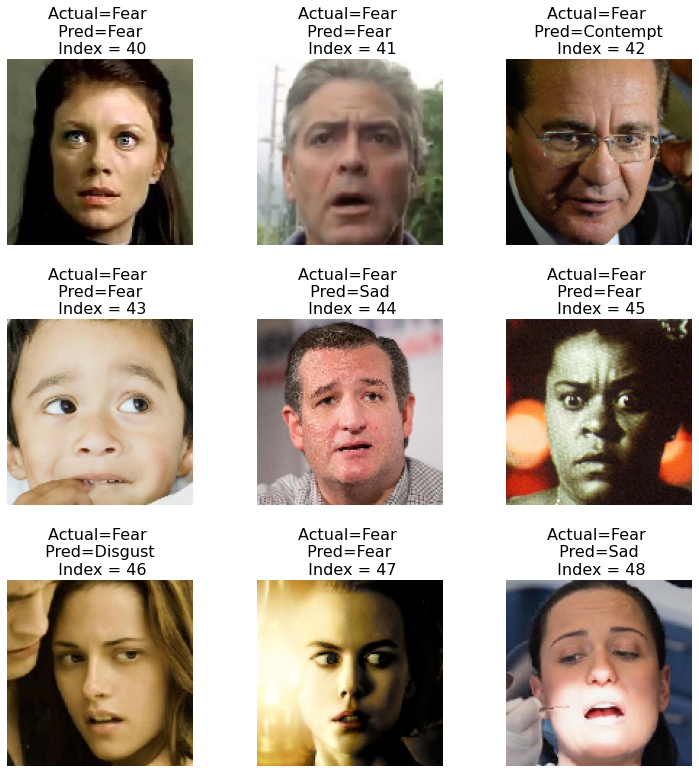

In [13]:
# displays first 9 images in array
start = 40

# gets labels for ground truth and predictions
true_labels = [CLASS_LABELS[idx] for idx in np.argmax(Y_img_true, axis=1)]
pred_labels = [CLASS_LABELS[idx] for idx in np.argmax(Y_img_pred, axis=1)]

display_nine_images(X_img, true_labels, pred_labels, start)

### FAU Dataset

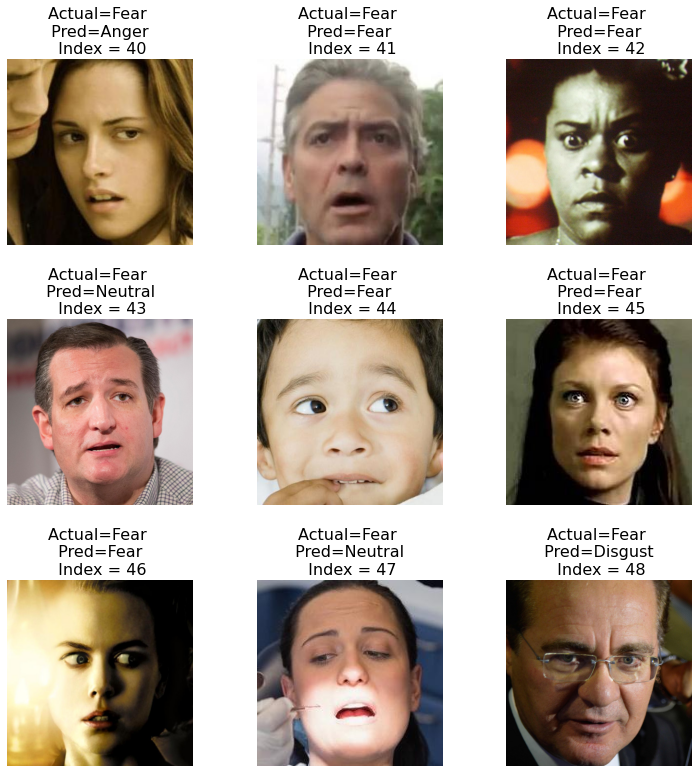

In [14]:
# displays first 9 images in array
start = 40

# Gets all images from folder
fau_images = [io.imread(f) for f in df_aus_xai.image]

# gets labels for ground truth and predictions
true_labels = [CLASS_LABELS[idx] for idx in Y_aus_true]
pred_labels = [CLASS_LABELS[idx] for idx in Y_aus_pred]

display_nine_images(fau_images, true_labels, pred_labels, start)

## PART 3: Explanations with DiCE
In this part of the notebook, you will generate Counterfactual Explanations using the Python Library, [Diverse Counterfactual Explanations (DiCE)](http://interpret.ml/DiCE/).

Counterfactual explanations typically work on tabular data, so in this part we will be using the FAU dataset.

In [29]:
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

In [31]:
# identify categorical and numerical features as needed by DiCE
categorical_features = list(df_aus_train.columns[df_aus_train.columns.str.contains('_c')])
numerical_features = list(df_aus_train.columns[df_aus_train.columns.str.contains('_r')])

all_features = numerical_features + categorical_features 

#### Task 3.0: Identify Some Images to Explain
- Review the FAU dataset using the helper code in part 2 above.
- Try changing start value to get a new set of images (there are 10 images for each class, so for example, the class happy will be at indexes 10-19)
- Search through the images to find at least 4 to explain 
    - Find classes that you would like to explain, and from each class select 2 images
        - one should be a correct prediction  
        - and one should be an incorrect prediction

In [35]:
#### Enter the Indexes Here ### 
###############################
# you will use this array later in the task
img_idxs = [41, 42, 60, 61]

### Task 3.1 
In this task, you will use DiCE to generate a set counterfactual explanations for your selected instances.

#### Task 3.1.1 Setup a DiCE explainer instance

See the [intro to DiCE](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html) for details on working with this library.

Note: data requires requires dataframe for creating explainers and explanations. 
- for setting up the explainer you can use the following to create a dataframe of features and classes from the training data
    - `df_aus_train[all_features+['class']`
- for generating instances to explain, you can use the following code:
    - `df_aus_xai[all_features][40:41]` where 40 is the index of instance to explan

In [34]:
##### YOUR CODE GOES HERE #####
###############################


########## SOLUTION ###########
###############################
d = dice_ml.Data(dataframe=df_aus_train[all_features+['class']], continuous_features=numerical_features, outcome_name='class')
m = dice_ml.Model(model=fer_rdf_model, backend='sklearn')
exp = dice_ml.Dice(d, m, method='random')

#### Task 3.1.2: Use the Explainer to Generate Counterfactual Explanations

Generate counterfacutal explanations for each of your select data instances from task 3.0.

In [36]:
##### YOUR CODE GOES HERE #####
###############################


########## SOLUTION ###########
###############################
exps = []
for idx in img_idxs:
    e = exp.generate_counterfactuals(df_aus_xai[all_features][40:41], total_CFs=5, desired_class=4)
    exps.append(e)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]


#### Task 3.1.3: Visualize Counterfactuals

Now visualize the images as Pandas dataframes

In [39]:
##### YOUR CODE GOES HERE #####
###############################
pd.set_option('display.max_columns', None) # so that Jupyter doesn't truncate columns of dataframe

########## SOLUTION ###########
###############################
for exp in exps:
    exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 6)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.04,0.0,1.74,0.03,0.0,0.59,0.51,1.01,0.0,0.11,0.24,0.52,0.0,0.0,0.59,1.18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,6



Diverse Counterfactual set (new outcome: 4)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,1.04,-,1.74,3.2,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
1,0.0,-,1.74,2.8,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
2,0.0,-,1.74,2.7,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
3,1.04,-,1.74,5.0,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
4,1.04,-,1.74,4.0,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4


Query instance (original outcome : 6)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.04,0.0,1.74,0.03,0.0,0.59,0.51,1.01,0.0,0.11,0.24,0.52,0.0,0.0,0.59,1.18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,6



Diverse Counterfactual set (new outcome: 4)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,1.04,-,1.74,4.9,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,1.4,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
1,1.04,-,1.74,2.8,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,2.6,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
2,1.04,-,1.74,4.5,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
3,0.0,-,1.74,2.4,-,0.59,0.51,1.0,-,1.01,0.24,0.52,-,-,0.59,1.0,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
4,1.04,-,1.74,2.7,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4


Query instance (original outcome : 6)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.04,0.0,1.74,0.03,0.0,0.59,0.51,1.01,0.0,0.11,0.24,0.52,0.0,0.0,0.59,1.18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,6



Diverse Counterfactual set (new outcome: 4)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.0,-,1.74,1.9,-,0.3,0.51,1.0,-,1.01,0.24,0.52,-,-,0.59,1.0,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
1,1.04,-,1.74,3.6,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
2,1.04,-,1.74,4.1,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-,0.0,1.0,1.0,0.0,0.0,4
3,1.04,-,1.74,4.4,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,4.2,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
4,0.0,-,1.74,2.3,-,0.59,0.51,1.0,-,0.0,0.24,0.52,-,-,0.59,1.0,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3


Query instance (original outcome : 6)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,0.04,0.0,1.74,0.03,0.0,0.59,0.51,1.01,0.0,0.11,0.24,0.52,0.0,0.0,0.59,1.18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,6



Diverse Counterfactual set (new outcome: 4)


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,class
0,1.04,-,1.74,5.0,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,4
1,1.04,-,1.74,4.6,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,4.2,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
2,1.04,-,1.74,3.0,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
3,1.04,-,1.74,3.2,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4
4,1.04,-,1.74,3.6,-,0.59,0.51,2.0100000000000007,-,1.01,0.24,0.52,-,-,0.59,2.0800000000000005,-,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4


#### Task 3.1.4: Describe your observations

![Action Units](./assets/fac.jpg)

1. Which features are most important for the detection of the specific facials expressions of your data instances?  Do the counterfactuals make sense according to your intuition of the contrastive expression class you're using
2. The `generate_counterfactuals` method has a parameter `features_to_vary` so that we can restrict which features are perturbed in CF generation.  Are there any AUs that shouldn't be perturbed for our task of emotion detection? Why or why not? Additionally, should we set `permitted_range` parameter to limit the ranges of our continous features?

Type your answer here...

### Task 3.2 Use the DiCE Explainer to Generate Feature Attribution Scores

DiCE can also generate [local and global feature attribution scores](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html#Generating-feature-attributions-(local-and-global)-using-DiCE) based on the identified counterfactuals.  In this task, we will do just that.  

In [ ]:
# function for plotting importance dictionaries provided by DiCE
def plot_importance_dict(importance_dict):
    keys = list(importance_dict.keys())
    vals = [float(importance_dict[k]) for k in keys]
    plt.figure(figsize=(20, 4))
    sns.barplot(x=keys, y=vals)
    plt.xticks(rotation=45)

#### Task 3.2.1 Generate and Plot Local Importance Scores

Using your previously defined DiCE explainer, generate and plot local importance scores your your data instances.

In [ ]:
##### YOUR CODE GOES HERE #####
###############################
# (you can use more than one notebook cell for this task)


########## SOLUTION ###########
###############################
for idx in img_idxs:
    imp = exp.local_feature_importance(df_aus_xai[all_features][idx:idx+1], desired_class=4)
    plot_importance_dict(imp.local_importance[0])

#### Task 3.2.2 Generate and Plot Local Importance Scores

Using your previously defined DiCE explainer, generate and plot global importance scores your your data instances.

In [ ]:
##### YOUR CODE GOES HERE #####
###############################


########## SOLUTION ###########
###############################
for idx in img_idxs:
    imp = exp.global_feature_importance(df_aus_xai[all_features][idx:idx+1], desired_class=4)
    plot_importance_dict(imp.global_importance[0])

#### Task 3.2.3 Describe your findings

![Action Units](./assets/fac.jpg)

1. How does DiCE calculate feature importance from counterfactuals?
1. Do the plots lead to any interesting insights regarding AUs or facial expression detection?

Write your answer here...

## Part 4 Explanations with the Alibi Inspection and Interpretation Library

[Alibi Explain](https://docs.seldon.io/projects/alibi/en/stable/index.html) is an open source python package for interpreting and inspecting machine learning models.  It contains many implementations of many highly relevant XAI methods, including ones that we have discussed through the sememster.  

In this part, you will select with explanation methods you would like to implement. To this end, you will review the documentation and [avaialble algorithms](https://docs.seldon.io/projects/alibi/en/stable/overview/algorithms.html) of Alibi and choose 2 methods to implement.  After implementation you will describe your findings and answer a few questions regarding the method. You can choose to use the image dataset with the CNN model, the FAU dataset with the RDF model, or both for your implementations.

#### Task 4.1.1: Implement 1 Explanation Method from Alibi

Select one XAI method from the list of avaialable XAI algorithms supported by Alibi.  Read the documention from Alibi regarding that method. The implment and explain at least one prediction using that method.  

In some cases, you will have some hyperparameters to select.  Try to evalaution a few different values for the hyperparameter to see their effects.  

**(Optional)** To assist with this, I have provided a function, `setup_gridsearch` for creating a grid of hyperparameters making a grid search easier.  To use this function simply pass it any number of python lists contain the values for HPs.  The function will create a list of tuples containing all possible combinations of HPs that you can then iterate over. Using grid search may take awhile depending on the time it takes to create one explanation.  

Example:

``` python
lrs = [0.001, 0.01, 0.1]
kappas = [0.01, 0.1, 1, 10]
betas = [0.001, 0.1, .9]

grid = setup_gridsearch(lrs, kappas, betas)

exps = []
for lr, kappa, beta in (pbar := tqdm.tqdm(grid)):
    pbar.set_description(f'{lr=}, {kappa=}, {beta}')
```


In [40]:
import itertools
def setup_gridsearch(*args):
    return list(itertools.product(*args))

In [ ]:
##### YOUR CODE GOES HERE #####
###############################


#### Task 4.1.2: Describe your implementation and findings

Answer the following questions regarding your implementation

1. Why did you select this method?
2. What hyperparameters are required? And what do they mean for the algorithm?  
3. Did you notice any effects of changing the HPs?
4. What does the output of this method represent?
5. We your able to identify any interesting findings regarding the dataset or explained prediction(s)?
6. Any other points regarding this method you found interesting?

Write your answers here...

#### Task 4.2.1: Implement a Different Explanation Method from Alibi

Select one XAI method from the list of avaialable XAI algorithms supported by Alibi.  Read the documention from Alibi regarding that method. The implment and explain at least one prediction using that method.  

In some cases, you will have some hyperparameters to select.  Try to evalaution a few different values for the hyperparameter to see their effects.  (see previous task for details)

In [ ]:
##### YOUR CODE GOES HERE #####
###############################


#### Task 4.2.2: Describe your implementation and findings

Answer the following questions regarding your implementation

1. Why did you select this method?
2. What hyperparameters are required? And what do they mean for the algorithm?  
3. Did you notice any effects of changing the HPs?
4. What does the output of this method represent?
5. We your able to identify any interesting findings regarding the dataset or explained prediction(s)?
6. Any other points regarding this method you found interesting?

Write your answers here...

# Scratch CEM

In [16]:
from alibi.explainers import CEM
print('Eager execution enabled: ', tf.executing_eagerly()) # False

Eager execution enabled:  False


#### Task 3.1 Setup Up CEM Explainers

Create an instance of both a Pertinent Pegative and a Pertinent Positive Explainer.

See the [Alibi CEM MNIST Tutorial](https://docs.seldon.io/projects/alibi/en/stable/examples/cem_mnist.html)

In [17]:
import tqdm

4 0.5662592 4


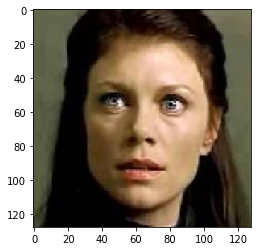

In [18]:
img_xai = X_img[40:41]
y_true = np.argmax(Y_img_true[40])
print(fer_cnn_model.predict(img_xai).argmax(), fer_cnn_model.predict(img_xai).max(), y_true)

plt.imshow(np.squeeze(img_xai))

In [19]:
##### YOUR CODE GOES HERE #####
###############################

shape = (1, IMG_HEIGHT, IMG_WIDTH, 3)
feature_range = (0.0, 1.0)

# reduce parameters if process takes too long...
no_info_val = 0.0
lrs = [0.001, 0.01, 0.1]
kappas = [0.01, 0.1, 1, 10]
betas = [0.001, 0.1, .9]

grid = setup_gridsearch(lrs, kappas, betas)

pn_exps = []
pp_exps = []
for lr, kappa, beta in (pbar := tqdm.tqdm(grid)):
    pbar.set_description(f'{lr=}, {kappa=}, {beta}')

    # required so CEM weights aren't frozen. 
    # see https://docs.seldon.io/projects/alibi/en/stable/methods/CEM.html
    tf.keras.backend.clear_session()

    # reloading weights asavefiger clearing session
    model_xai = cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
    model_xai.load_weights(model_path)

    # Implementation of explainers
    cem_pn_explainer = CEM(model_xai, mode='PN', shape=shape, 
                           feature_range=feature_range, kappa=kappa, beta=beta,
                           learning_rate_init=lr, no_info_val=no_info_val)
    cem_pp_explainer = CEM(model_xai, mode='PP', shape=shape, 
                           feature_range=feature_range, kappa=kappa, beta=beta,
                           learning_rate_init=lr, no_info_val=no_info_val)
    
    # Get explanations of your instance
    pn_exps.append(cem_pn_explainer.explain(img_xai))
    pp_exps.append(cem_pp_explainer.explain(img_xai))    

lr=0.001, kappa=0.01, 0.1:   3%|███                                                                                                          | 1/36 [10:35<6:10:37, 635.34s/it]2022-06-04 23:02:34.357923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
No PN found!
lr=0.001, kappa=0.01, 0.9:   6%|██████                                                                                                       | 2/36 [21:01<5:57:07, 630.21s/it]2022-06-04 23:13:01.269577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
No PN found!
lr=0.001, kappa=0.1, 0.1:  11%|████████████▏                                                            

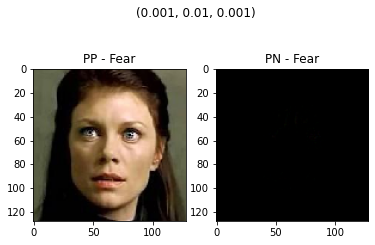

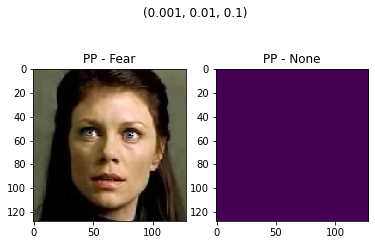

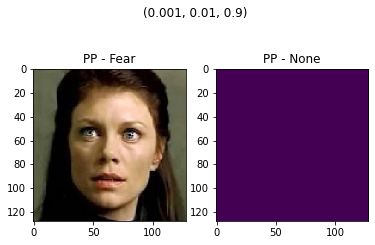

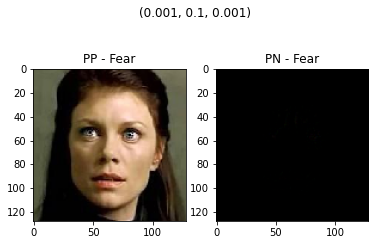

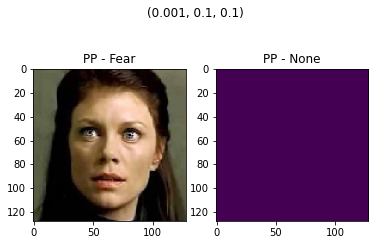

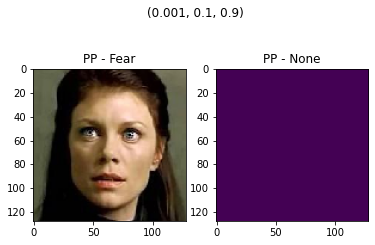

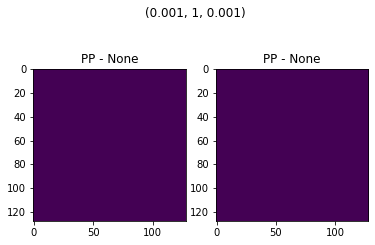

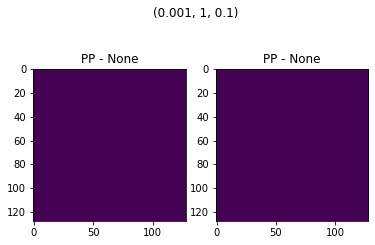

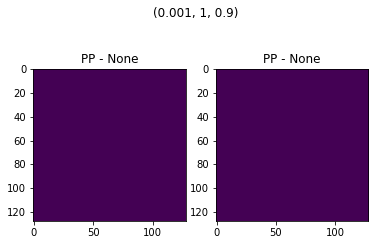

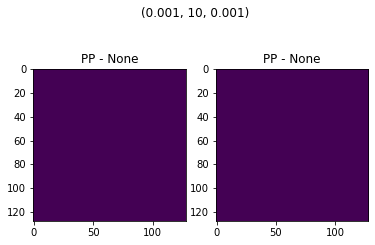

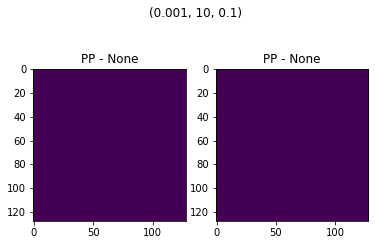

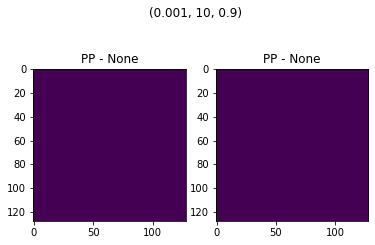

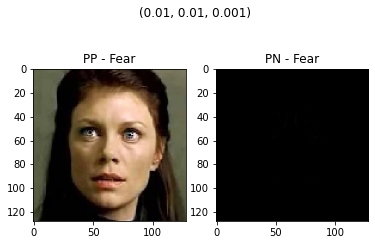

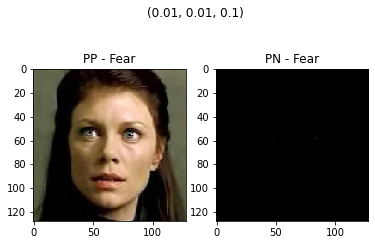

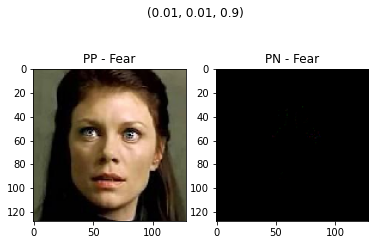

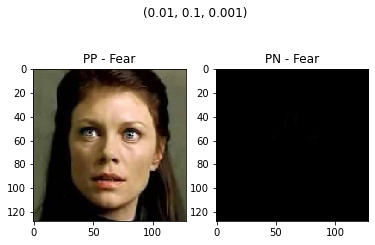

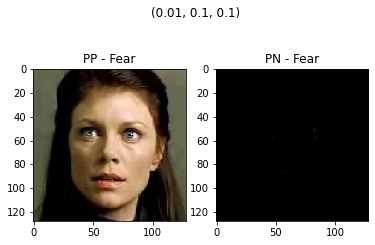

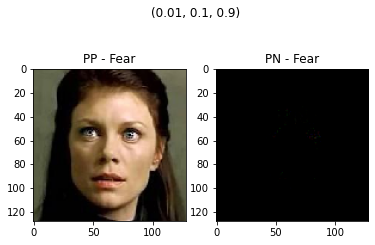

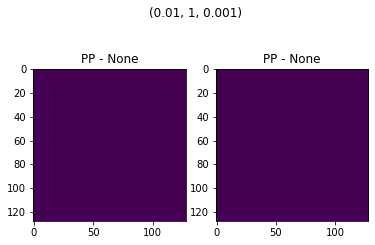

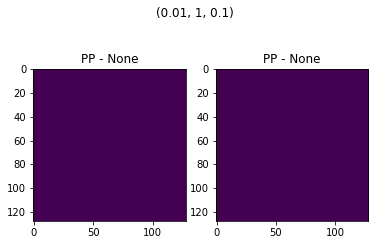

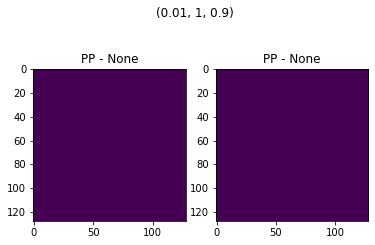

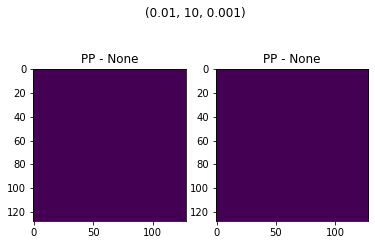

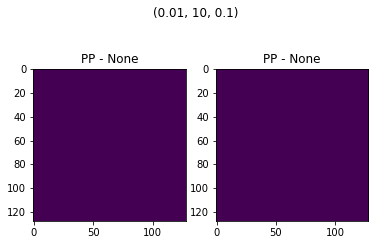

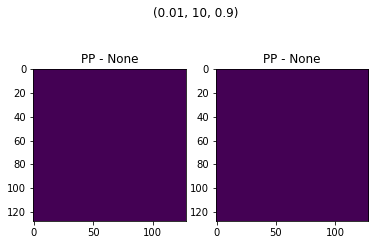

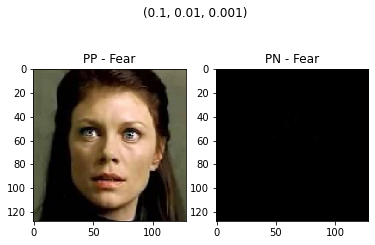

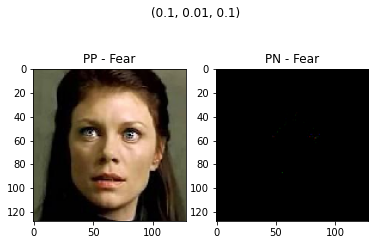

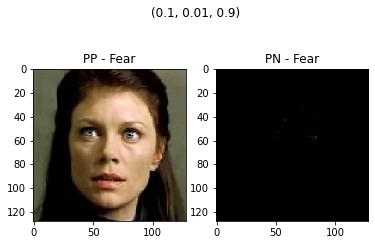

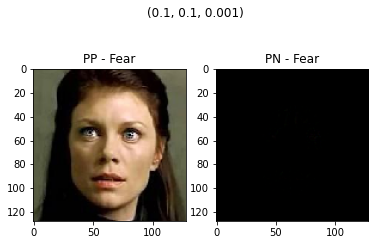

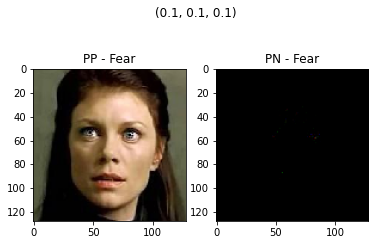

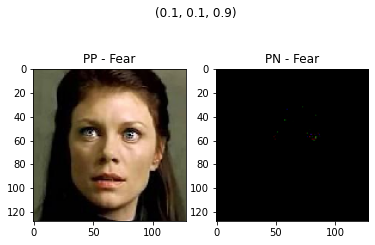

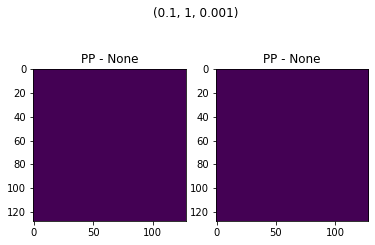

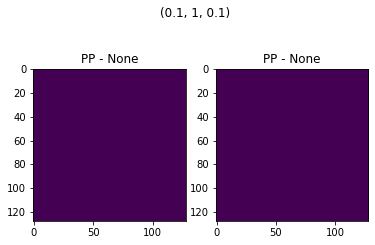

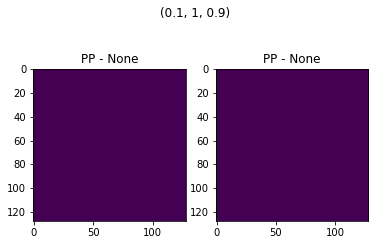

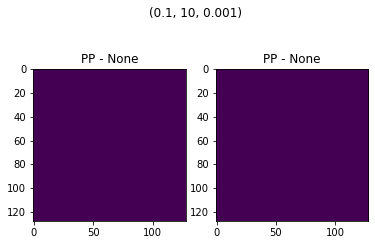

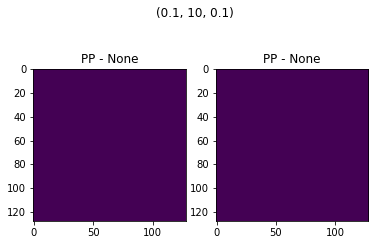

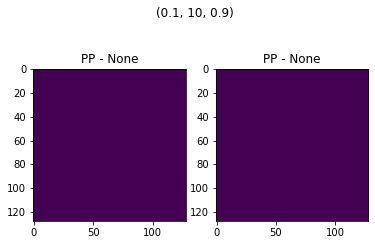

In [23]:

for exp_pp, exp_pn, params in zip(pp_exps, pn_exps, grid):
    plt.figure()
    plt.suptitle(params)
    plt.subplot(121)
    if exp_pp.PP is not None:
        plt.imshow(abs(np.squeeze(img_xai) - np.squeeze(exp_pp.PP)))
        plt.title(f'PP - {CLASS_LABELS[exp_pp.X_pred]}')
    else:
        plt.imshow(np.zeros((128, 128)))
        plt.title(f'PP - {"None"}')
    plt.subplot(122)
    if exp_pn.PN is not None:
        plt.imshow(abs(np.squeeze(img_xai) - np.squeeze(exp_pn.PN)))
        plt.title(f'PN - {CLASS_LABELS[exp_pn.X_pred]}')
    else:
        plt.imshow(np.zeros((128, 128)))
        plt.title(f'PP - {"None"}')
    plt.savefig(f'lr={params[0]}_kappa={params[1]}_beta={params[2]}.pdf')

#### Task 3.2 CEMS on Tabular Data

In [25]:
shape = (1,) + X_aus.shape[1:]  # instance shape
kappa = .1  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .05  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 20  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (X_aus.min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 X_aus.max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate


In [41]:
predict_fn = fer_rdf_model.predict_proba

eps0 = np.array([[1e-2 ] * len(CLASS_LABELS)])  # 3 prediction categories, equivalent to 1e-2
eps1 = np.array([[1e-2] * len(all_features)])  # 4 features, also equivalent to 1e-2
eps = (eps0, eps1)

print(eps0.shape, eps1.shape)


update_num_grad = 100

# initialize CEM explainer and explain instance
cem_pn = CEM(predict_fn, 'PN', shape, kappa=kappa, beta=beta,
             feature_range=feature_range, max_iterations=max_iterations,
             eps=eps, c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init,
             clip=clip, update_num_grad=update_num_grad, no_info_val=0.5)
cem_pp = CEM(predict_fn, 'PP', shape, kappa=kappa, beta=beta,
             feature_range=feature_range, max_iterations=max_iterations,
             eps=eps, c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init,
             clip=clip, update_num_grad=update_num_grad, no_info_val=0.5)

(1, 8) (1, 35)


In [43]:
exp_pn = cem_pn.explain(X_aus[40:41], verbose=False)
exp_pp = cem_pp.explain(X_aus[40:41], verbose=False)

No PP found!


In [44]:
CLASS_LABELS[explanation.X_pred], CLASS_LABELS[4]

NameError: name 'explanation' is not defined

In [ ]:
plt.figure(figsize=(20,4))

x = np.arange(len(all_features))
width = 0.35

plt.bar(x-width/2, np.squeeze(exp_pp.PP), width, label='PP')
plt.bar(x+width/2, np.squeeze(exp_pp.X), width, label='Orig')
plt.xticks(x, all_features, rotation=45);
plt.legend()